In [1]:
#!/usr/bin/env python
# coding: utf-8

In [2]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [5]:
telecom_df = pd.read_csv(".datasets/telecom_churn_data.csv")
telecom_df.head()


,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [7]:
telecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [8]:
telecom_df.shape

(99999, 226)

In [9]:
init_rows, init_cols = telecom_df.shape
print("Number of rows", init_rows)
print("Number of columns", init_cols)

Number of rows 99999
Number of columns 226


In [10]:
missing_percent = pd.DataFrame(round(100*(telecom_df.isnull().sum()/len(telecom_df.index)), 2), columns=['Percentage'])
missing_percent.reset_index(inplace=True)
missing_percent.rename(columns={'index':'features'}, inplace=True)

print("missing percentage < 10% ", missing_percent[(missing_percent['Percentage'] > 0.00) & (missing_percent['Percentage'] < 10.00)].count())
print("missing percentage 10-60% ", missing_percent[(missing_percent['Percentage'] >= 10.00) & (missing_percent['Percentage'] < 60.00)].count())
print("missing percentage >= 60% ", missing_percent[(missing_percent['Percentage'] >= 60.00)].count())


missing percentage < 10%  features      126
Percentage    126
dtype: int64
missing percentage 10-60%  features      0
Percentage    0
dtype: int64
missing percentage >= 60%  features      40
Percentage    40
dtype: int64


In [11]:
missing_percent[(missing_percent['Percentage'] > 60.00)]

,features,Percentage
157,date_of_last_rech_data_6,74.85
158,date_of_last_rech_data_7,74.43
159,date_of_last_rech_data_8,73.66
160,date_of_last_rech_data_9,74.08
161,total_rech_data_6,74.85
162,total_rech_data_7,74.43
163,total_rech_data_8,73.66
164,total_rech_data_9,74.08
165,max_rech_data_6,74.85
166,max_rech_data_7,74.43


In [12]:
telecom_df.fb_user_8.value_counts()

fb_user_8
1.0    23463
0.0     2876
Name: count, dtype: int64

In [13]:
no_data_rech_cols = list(missing_percent[(missing_percent['Percentage'] > 60.00)].features)
no_data_rech_cols

['date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'date_of_last_rech_data_9',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'total_rech_data_9',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'max_rech_data_9',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_2g_9',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'count_rech_3g_9',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'av_rech_amt_data_9',
 'arpu_3g_6',
 'arpu_3g_7',
 'arpu_3g_8',
 'arpu_3g_9',
 'arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8',
 'arpu_2g_9',
 'night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8',
 'night_pck_user_9',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8',
 'fb_user_9']

In [14]:
telecom_df[no_data_rech_cols] = telecom_df[no_data_rech_cols].fillna(value=0)

In [15]:
missing_percent = pd.DataFrame(round(100*(telecom_df.isnull().sum()/len(telecom_df.index)), 2), columns=['Percentage'])
missing_percent.reset_index(inplace=True)
missing_percent.rename(columns={'index':'features'}, inplace=True)

print("missing percentage > 60% ", missing_percent[(missing_percent['Percentage'] > 60.00)].count())




missing percentage > 60%  features      0
Percentage    0
dtype: int64


In [16]:
missing_percent[(missing_percent['Percentage'] > 0.00) & (missing_percent['Percentage'] < 10.00)]


,features,Percentage
2,loc_og_t2o_mou,1.02
3,std_og_t2o_mou,1.02
4,loc_ic_t2o_mou,1.02
6,last_date_of_month_7,0.60
7,last_date_of_month_8,1.10
...,...,...
136,ic_others_9,7.75
149,date_of_last_rech_6,1.61
150,date_of_last_rech_7,1.77
151,date_of_last_rech_8,3.62


In [17]:
telecom_df['loc_og_t2o_mou'].value_counts()

loc_og_t2o_mou
0.0    98981
Name: count, dtype: int64

In [18]:
telecom_df['std_og_t2o_mou'].value_counts()

std_og_t2o_mou
0.0    98981
Name: count, dtype: int64

In [19]:
telecom_df['loc_ic_t2o_mou'].value_counts()

loc_ic_t2o_mou
0.0    98981
Name: count, dtype: int64

In [20]:
telecom_df.drop(['std_og_t2o_mou', 'loc_og_t2o_mou', 'loc_ic_t2o_mou'], axis=1, inplace=True)
telecom_df.head()

,mobile_number,circle_id,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,...,0,1.0,1.0,1.0,0.0,968,30.4,0.0,101.20,3.58
1,7001865778,109,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,355.074,268.321,86.285,...,0,0.0,1.0,1.0,0.0,1006,0.0,0.0,0.00,0.00
2,7001625959,109,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,189.058,210.226,290.714,...,0,0.0,0.0,0.0,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,251.102,508.054,389.500,...,0,0.0,0.0,0.0,0.0,2491,0.0,0.0,0.00,0.00
4,7000142493,109,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,309.876,238.174,163.426,...,0,0.0,0.0,0.0,0.0,1526,0.0,0.0,0.00,0.00


In [21]:
telecom_df['last_date_of_month_7'] = telecom_df['last_date_of_month_7'].fillna(value='7/31/2014')
telecom_df['last_date_of_month_8'] = telecom_df['last_date_of_month_8'].fillna(value='8/31/2014')
telecom_df['last_date_of_month_9'] = telecom_df['last_date_of_month_9'].fillna(value='9/30/2014')



In [22]:
telecom_df['date_of_last_rech_6'].value_counts()

date_of_last_rech_6
6/30/2014    16960
6/29/2014    12918
6/27/2014    11169
6/28/2014     9491
6/26/2014     5530
6/25/2014     4896
6/17/2014     4145
6/24/2014     4129
6/14/2014     3845
6/21/2014     3747
6/23/2014     2908
6/18/2014     2747
6/12/2014     2511
6/22/2014     2344
6/13/2014     2147
6/19/2014     2009
6/20/2014     1803
6/16/2014     1126
6/15/2014      873
6/11/2014      579
6/8/2014       520
6/5/2014       327
6/7/2014       322
6/10/2014      283
6/3/2014       233
6/1/2014       218
6/9/2014       199
6/6/2014       173
6/4/2014       131
6/2/2014       109
Name: count, dtype: int64

In [23]:
telecom_df['date_of_last_rech_7'].value_counts()

date_of_last_rech_7
7/31/2014    17288
7/30/2014    13863
7/25/2014     9401
7/29/2014     9052
7/28/2014     7502
7/27/2014     5909
7/26/2014     5382
7/24/2014     3998
7/19/2014     3057
7/22/2014     2969
7/20/2014     2892
7/17/2014     2737
7/16/2014     2458
7/23/2014     2302
7/21/2014     1640
7/15/2014     1562
7/18/2014     1280
7/10/2014      859
7/9/2014       827
7/12/2014      732
7/14/2014      452
7/11/2014      408
7/13/2014      324
7/6/2014       313
7/4/2014       251
7/8/2014       201
7/7/2014       153
7/3/2014       153
7/5/2014       125
7/1/2014        74
7/2/2014        68
Name: count, dtype: int64

In [24]:
telecom_df['date_of_last_rech_8'].value_counts()


date_of_last_rech_8
8/31/2014    14706
8/30/2014    11707
8/29/2014    10057
8/28/2014     9816
8/26/2014     9297
8/24/2014     7722
8/25/2014     7655
8/27/2014     5688
8/22/2014     2017
8/20/2014     1986
8/23/2014     1806
8/19/2014     1590
8/21/2014     1347
8/18/2014     1027
8/9/2014       984
8/5/2014       943
8/14/2014      890
8/15/2014      813
8/16/2014      756
8/17/2014      735
8/12/2014      716
8/13/2014      705
8/8/2014       676
8/6/2014       618
8/11/2014      555
8/7/2014       447
8/10/2014      361
8/1/2014       254
8/2/2014       206
8/4/2014       170
8/3/2014       127
Name: count, dtype: int64

In [25]:
telecom_df['date_of_last_rech_9'].value_counts()

date_of_last_rech_9
9/29/2014    22623
9/30/2014    21713
9/28/2014    10601
9/27/2014     6473
9/26/2014     6282
9/25/2014     5617
9/24/2014     3224
9/21/2014     2888
9/20/2014     2579
9/23/2014     2435
9/22/2014     1617
9/19/2014     1109
9/16/2014      889
9/17/2014      753
9/18/2014      653
9/14/2014      608
9/11/2014      555
9/15/2014      535
9/10/2014      481
9/12/2014      443
9/13/2014      440
9/9/2014       434
9/6/2014       434
9/2/2014       429
9/3/2014       338
9/5/2014       295
9/8/2014       257
9/4/2014       202
9/7/2014       199
9/1/2014       133
Name: count, dtype: int64

In [26]:
telecom_df['date_of_last_rech_6'] = telecom_df['date_of_last_rech_6'].fillna(
    value=telecom_df['date_of_last_rech_6'].mode()[0])

telecom_df['date_of_last_rech_7'] = telecom_df['date_of_last_rech_7'].fillna(
    value=telecom_df['date_of_last_rech_7'].mode()[0])

telecom_df['date_of_last_rech_8'] = telecom_df['date_of_last_rech_8'].fillna(
    value=telecom_df['date_of_last_rech_8'].mode()[0])

telecom_df['date_of_last_rech_9'] = telecom_df['date_of_last_rech_9'].fillna(
    value=telecom_df['date_of_last_rech_9'].mode()[0])

In [27]:
missing_percent = pd.DataFrame(round(100*(telecom_df.isnull().sum()/len(telecom_df.index)), 2), columns=['Percentage'])
missing_percent.reset_index(inplace=True)
missing_percent.rename(columns={'index':'features'}, inplace=True)

print("missing percentage < 10% ", missing_percent[(missing_percent['Percentage'] > 0.00) & (missing_percent['Percentage'] < 10.00)].count())
print("missing percentage 10-60% ", missing_percent[(missing_percent['Percentage'] >= 10.00) & (missing_percent['Percentage'] < 60.00)].count())
print("missing percentage >= 60% ", missing_percent[(missing_percent['Percentage'] >= 60.00)].count())



missing percentage < 10%  features      116
Percentage    116
dtype: int64
missing percentage 10-60%  features      0
Percentage    0
dtype: int64
missing percentage >= 60%  features      0
Percentage    0
dtype: int64


In [28]:
missing_percent[(missing_percent['Percentage'] > 0.00) & (missing_percent['Percentage'] < 10.00)]


,features,Percentage
10,onnet_mou_6,3.94
11,onnet_mou_7,3.86
12,onnet_mou_8,5.38
13,onnet_mou_9,7.75
14,offnet_mou_6,3.94
...,...,...
129,isd_ic_mou_9,7.75
130,ic_others_6,3.94
131,ic_others_7,3.86
132,ic_others_8,5.38


In [29]:
missing_cols = missing_percent[(missing_percent['Percentage'] == 3.94) | (missing_percent['Percentage'] == 3.86) |
                                (missing_percent['Percentage'] == 5.38) | (missing_percent['Percentage'] == 7.75)].features

telecom_df[missing_cols] = telecom_df[missing_cols].fillna(value=0)


In [30]:
missing_percent = pd.DataFrame(round(100*(telecom_df.isnull().sum()/len(telecom_df.index)), 2), columns=['Percentage'])
missing_percent.reset_index(inplace=True)
missing_percent.rename(columns={'index':'features'}, inplace=True)

print("missing percentage < 10% ", missing_percent[(missing_percent['Percentage'] > 0.00) & (missing_percent['Percentage'] < 10.00)].count())
print("missing percentage 10-60% ", missing_percent[(missing_percent['Percentage'] >= 10.00) & (missing_percent['Percentage'] < 60.00)].count())
print("missing percentage >= 60% ", missing_percent[(missing_percent['Percentage'] >= 60.00)].count())


missing percentage < 10%  features      0
Percentage    0
dtype: int64
missing percentage 10-60%  features      0
Percentage    0
dtype: int64
missing percentage >= 60%  features      0
Percentage    0
dtype: int64


In [31]:
telecom_df['av_total_rech_goodPhase'] = (telecom_df['total_rech_amt_6'] + telecom_df['total_rech_amt_7'])/(
    telecom_df['total_rech_num_6'] + telecom_df['total_rech_num_7'])

var = round(telecom_df['av_total_rech_goodPhase'].quantile(0.7), 2)
print("70% of average Recharge Amount of month 6 and 7", var)


HV_Cust_df = telecom_df[(telecom_df.av_total_rech_goodPhase >= var)]
HV_Cust_df.info()

70% of average Recharge Amount of month 6 and 7 56.39
<class 'pandas.core.frame.DataFrame'>
Index: 29944 entries, 0 to 99998
Columns: 224 entries, mobile_number to av_total_rech_goodPhase
dtypes: float64(177), int64(35), object(12)
memory usage: 51.4+ MB


In [32]:
HV_Cust_df.drop(['av_total_rech_goodPhase'], axis=1, inplace=True)


In [33]:
var_list = ['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9']
churn_info = HV_Cust_df[var_list]
churn_info.head()


,total_ic_mou_9,total_og_mou_9,vol_2g_mb_9,vol_3g_mb_9
0,0.00,0.00,0.0,0.0
7,0.00,0.00,0.0,0.0
9,412.63,151.33,0.0,0.0
13,631.86,446.09,0.0,0.0
16,334.56,255.74,0.0,0.0


In [34]:
churn_info.isnull().sum()


total_ic_mou_9    0
total_og_mou_9    0
vol_2g_mb_9       0
vol_3g_mb_9       0
dtype: int64

In [35]:
def churn_detect(df):
    if((df['total_ic_mou_9'] == 0.0) & (df['total_og_mou_9'] == 0.0)
      & (df['vol_2g_mb_9'] == 0.0) & (df['vol_3g_mb_9'] == 0.0)):
        return 1
    else:
        return 0

# Applying User defined Churn detection function HV_Cust_df and creating new column Churn    
HV_Cust_df['Churn'] = churn_info.apply(churn_detect, axis=1) 

In [36]:
churn_info['Churn'] = HV_Cust_df['Churn']
churn_info.head(10)

,total_ic_mou_9,total_og_mou_9,vol_2g_mb_9,vol_3g_mb_9,Churn
0,0.00,0.00,0.00,0.00,1
7,0.00,0.00,0.00,0.00,1
9,412.63,151.33,0.00,0.00,0
13,631.86,446.09,0.00,0.00,0
16,334.56,255.74,0.00,0.00,0
19,50.38,25.31,0.00,0.00,0
20,240.93,293.83,0.00,0.00,0
22,7.51,0.68,0.00,0.00,0
23,127.48,127.63,13.93,314.74,0
24,330.03,627.78,0.00,0.00,0


In [37]:
Nonchurn_phase_cols = [i  for i in HV_Cust_df.columns if "_9" not in i]
len(Nonchurn_phase_cols)


170

In [38]:
HVC_telecom = HV_Cust_df[Nonchurn_phase_cols]
HVC_telecom.head()


,mobile_number,circle_id,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,...,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,Churn
0,7000842753,109,6/30/2014,7/31/2014,8/31/2014,197.385,214.816,213.803,0.00,0.00,...,0,1.0,1.0,1.0,968,30.40,0.00,101.20,3.58,1
7,7000701601,109,6/30/2014,7/31/2014,8/31/2014,1069.180,1349.850,3171.480,57.84,54.68,...,0,0.0,0.0,0.0,802,57.74,19.38,18.74,0.00,1
9,7001864400,109,6/30/2014,7/31/2014,8/31/2014,119.518,247.435,170.231,33.89,30.11,...,0,0.0,1.0,0.0,902,0.00,0.00,0.00,0.00,0
13,7002191713,109,6/30/2014,7/31/2014,8/31/2014,492.846,205.671,593.260,501.76,108.39,...,0,0.0,0.0,1.0,2607,0.00,0.00,0.00,0.00,0
16,7000875565,109,6/30/2014,7/31/2014,8/31/2014,430.975,299.869,187.894,50.51,74.01,...,0,0.0,0.0,0.0,511,0.00,2.45,21.89,0.00,0


In [39]:
HVC_telecom.shape

(29944, 170)

In [41]:
HVC_telecom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29944 entries, 0 to 99998
Columns: 170 entries, mobile_number to Churn
dtypes: float64(133), int64(28), object(9)
memory usage: 39.1+ MB


In [42]:
HVC_telecom['std_ic_t2o_mou_6'].value_counts()

std_ic_t2o_mou_6
0.0    29944
Name: count, dtype: int64

In [43]:
HVC_telecom['std_ic_t2o_mou_7'].value_counts()


std_ic_t2o_mou_7
0.0    29944
Name: count, dtype: int64

In [44]:
HVC_telecom['std_ic_t2o_mou_8'].value_counts()

std_ic_t2o_mou_8
0.0    29944
Name: count, dtype: int64

In [45]:
HVC_telecom['std_og_t2c_mou_6'].value_counts()

std_og_t2c_mou_6
0.0    29944
Name: count, dtype: int64

In [46]:
HVC_telecom['std_og_t2c_mou_7'].value_counts()

std_og_t2c_mou_7
0.0    29944
Name: count, dtype: int64

In [47]:
HVC_telecom['std_og_t2c_mou_8'].value_counts()

std_og_t2c_mou_8
0.0    29944
Name: count, dtype: int64

In [48]:
drop_cols = ['std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8']
HVC_telecom.drop(columns=drop_cols, axis=1, inplace=True)

In [49]:
HVC_telecom.drop(['mobile_number'], axis=1, inplace=True)

In [50]:
HVC_telecom.head()

,circle_id,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,...,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,Churn
0,109,6/30/2014,7/31/2014,8/31/2014,197.385,214.816,213.803,0.00,0.00,0.00,...,0,1.0,1.0,1.0,968,30.40,0.00,101.20,3.58,1
7,109,6/30/2014,7/31/2014,8/31/2014,1069.180,1349.850,3171.480,57.84,54.68,52.29,...,0,0.0,0.0,0.0,802,57.74,19.38,18.74,0.00,1
9,109,6/30/2014,7/31/2014,8/31/2014,119.518,247.435,170.231,33.89,30.11,22.43,...,0,0.0,1.0,0.0,902,0.00,0.00,0.00,0.00,0
13,109,6/30/2014,7/31/2014,8/31/2014,492.846,205.671,593.260,501.76,108.39,534.24,...,0,0.0,0.0,1.0,2607,0.00,0.00,0.00,0.00,0
16,109,6/30/2014,7/31/2014,8/31/2014,430.975,299.869,187.894,50.51,74.01,70.61,...,0,0.0,0.0,0.0,511,0.00,2.45,21.89,0.00,0


In [51]:
HVC_telecom.circle_id.value_counts()

circle_id
109    29944
Name: count, dtype: int64

In [52]:
HVC_telecom.drop(['circle_id'], axis=1, inplace=True)

In [53]:
date_cols = [cols for cols in HVC_telecom.columns if "date" in cols]
date_cols


['last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8']

In [54]:
HVC_telecom[date_cols].head()

,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8
0,6/30/2014,7/31/2014,8/31/2014,6/21/2014,7/16/2014,8/8/2014,6/21/2014,7/16/2014,8/8/2014
7,6/30/2014,7/31/2014,8/31/2014,6/27/2014,7/25/2014,8/26/2014,0,0,0
9,6/30/2014,7/31/2014,8/31/2014,6/29/2014,7/23/2014,8/29/2014,0,7/23/2014,0
13,6/30/2014,7/31/2014,8/31/2014,6/20/2014,7/22/2014,8/30/2014,0,0,8/30/2014
16,6/30/2014,7/31/2014,8/31/2014,6/30/2014,7/31/2014,8/14/2014,0,0,0


In [56]:
HVC_telecom[date_cols] = HVC_telecom[date_cols].apply(pd.to_datetime, errors='coerce')


In [57]:
HVC_telecom[date_cols].head()

,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8
0,2014-06-30,2014-07-31,2014-08-31,2014-06-21,2014-07-16,2014-08-08,2014-06-21,2014-07-16,2014-08-08
7,2014-06-30,2014-07-31,2014-08-31,2014-06-27,2014-07-25,2014-08-26,NaT,NaT,NaT
9,2014-06-30,2014-07-31,2014-08-31,2014-06-29,2014-07-23,2014-08-29,NaT,2014-07-23,NaT
13,2014-06-30,2014-07-31,2014-08-31,2014-06-20,2014-07-22,2014-08-30,NaT,NaT,2014-08-30
16,2014-06-30,2014-07-31,2014-08-31,2014-06-30,2014-07-31,2014-08-14,NaT,NaT,NaT


In [58]:
def find_last_rech(df, str_month_num):
    diff1 = df['last_date_of_month_'+str_month_num] - df['date_of_last_rech_'+str_month_num]
    diff2 = df['last_date_of_month_'+str_month_num] - df['date_of_last_rech_data_'+str_month_num]
    if(diff1.dt.days <= diff2.dt.days).any():
        return diff1.dt.days
    else:
        return diff2.dt.days
    
    
# Applying the function for all months
HVC_telecom['last_rech_day_6'] = find_last_rech(HVC_telecom, "6")
HVC_telecom['last_rech_day_7'] = find_last_rech(HVC_telecom, "7")
HVC_telecom['last_rech_day_8'] = find_last_rech(HVC_telecom, "8")

In [59]:
HVC_telecom.drop(columns=date_cols, axis=1, inplace=True)


In [60]:
HVC_telecom.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,Churn,last_rech_day_6,last_rech_day_7,last_rech_day_8
0,197.385,214.816,213.803,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.0,968,30.40,0.00,101.20,3.58,1,9,15,23
7,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,...,0.0,802,57.74,19.38,18.74,0.00,1,3,6,5
9,119.518,247.435,170.231,33.89,30.11,22.43,63.48,54.16,78.34,0.00,...,0.0,902,0.00,0.00,0.00,0.00,0,1,8,2
13,492.846,205.671,593.260,501.76,108.39,534.24,413.31,119.28,482.46,23.53,...,1.0,2607,0.00,0.00,0.00,0.00,0,10,9,1
16,430.975,299.869,187.894,50.51,74.01,70.61,296.29,229.74,162.76,0.00,...,0.0,511,0.00,2.45,21.89,0.00,0,0,0,17


In [62]:
HVC_telecom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29944 entries, 0 to 99998
Columns: 156 entries, arpu_6 to last_rech_day_8
dtypes: float64(127), int64(29)
memory usage: 35.9 MB


In [63]:
cols_int = [i for i in HVC_telecom.columns if ("count" in i) or ("fb" in i)]

# total 6 columns are there for recharge count
cols_int.extend(['total_rech_num_6','total_rech_num_7', 'total_rech_num_8', 
                'total_rech_data_6','total_rech_data_7', 'total_rech_data_8'])

cols_int


['count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8',
 'total_rech_num_6',
 'total_rech_num_7',
 'total_rech_num_8',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8']

In [65]:
HVC_telecom[cols_int] = HVC_telecom[cols_int].astype('int64')

HVC_telecom.info()


<class 'pandas.core.frame.DataFrame'>
Index: 29944 entries, 0 to 99998
Columns: 156 entries, arpu_6 to last_rech_day_8
dtypes: float64(115), int64(41)
memory usage: 35.9 MB


In [66]:
HVC_telecom.head(10)

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,Churn,last_rech_day_6,last_rech_day_7,last_rech_day_8
0,197.385,214.816,213.803,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1,968,30.40,0.00,101.20,3.58,1,9,15,23
7,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,...,0,802,57.74,19.38,18.74,0.00,1,3,6,5
9,119.518,247.435,170.231,33.89,30.11,22.43,63.48,54.16,78.34,0.00,...,0,902,0.00,0.00,0.00,0.00,0,1,8,2
13,492.846,205.671,593.260,501.76,108.39,534.24,413.31,119.28,482.46,23.53,...,1,2607,0.00,0.00,0.00,0.00,0,10,9,1
16,430.975,299.869,187.894,50.51,74.01,70.61,296.29,229.74,162.76,0.00,...,0,511,0.00,2.45,21.89,0.00,0,0,0,17
19,163.430,241.218,326.920,4.04,7.38,13.61,0.51,41.28,9.46,0.00,...,1,1104,454.53,466.06,0.00,0.00,0,3,6,5
20,271.699,421.474,364.251,72.41,86.73,71.18,198.84,225.38,132.51,0.00,...,0,3108,1.11,0.22,0.00,0.00,0,16,21,4
22,281.076,26.291,0.000,36.59,5.09,0.00,388.51,5.13,0.00,0.00,...,0,396,0.00,0.00,0.00,0.00,0,11,28,3
23,74.350,193.897,366.966,48.96,50.66,33.58,85.41,89.36,205.89,0.00,...,1,604,40.45,51.86,0.00,0.00,0,12,24,7
24,422.050,359.730,354.793,124.19,55.19,141.11,450.33,370.48,283.36,9.30,...,0,3072,0.00,0.00,0.00,0.00,0,7,14,0


In [67]:
100*(HVC_telecom.Churn.value_counts(normalize=True))

Churn
0    91.310446
1     8.689554
Name: proportion, dtype: float64

In [68]:
mou_cols = [i for i in HVC_telecom.columns if "mou" in i]
print("Total MOU attributes", len(mou_cols))

HVC_telecom[mou_cols].describe()

Total MOU attributes 81


,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,...,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8
count,29944.000000,29944.000000,29944.000000,29944.000000,29944.000000,29944.000000,29944.000000,29944.000000,29944.000000,29944.000000,...,29944.000000,29944.000000,29944.000000,29944.000000,29944.000000,29944.000000,29944.000000,29944.000000,29944.000000,29944.000000
mean,215.806269,216.449542,195.627181,329.774497,329.255905,300.435473,15.834159,12.316899,12.126366,25.837412,...,42.869734,274.042211,279.592188,267.660504,0.053767,0.013004,0.020984,11.336265,12.281301,11.361568
std,408.813705,420.785528,403.907438,439.251291,453.748322,438.463262,72.485743,69.479316,66.913546,112.123819,...,132.079963,330.109976,341.970210,332.599423,0.139624,0.090914,0.107614,83.460799,87.257671,72.539676
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.597500,18.110000,13.097500,81.902500,75.130000,58.005000,0.000000,0.000000,0.000000,0.000000,...,0.360000,73.125000,77.510000,64.475000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,74.880000,70.185000,61.030000,198.235000,191.990000,171.260000,0.000000,0.000000,0.000000,0.000000,...,8.910000,182.185000,185.190000,176.735000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,216.945000,213.015000,188.280000,405.910000,404.050000,376.450000,0.000000,0.000000,0.000000,0.000000,...,37.360000,357.310000,361.952500,349.412500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7376.710000,8157.780000,10752.560000,8362.360000,9667.130000,14007.340000,2589.090000,2877.060000,2663.110000,3775.110000,...,5957.140000,7074.590000,9699.010000,10830.380000,3.560000,6.430000,6.230000,6789.410000,5289.540000,4127.010000


In [69]:
HVC_telecom[['max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 
             'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8']].describe(percentiles=[.25,.5,.75,.90,.95,.99])



,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8
count,29944.000000,29944.000000,29944.000000,29944.000000,29944.000000,29944.000000
mean,62.562016,63.014527,59.461528,88.399412,92.021679,86.278520
std,111.275324,112.187623,109.136924,188.866476,194.415702,184.297543
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,152.000000,152.000000,145.000000,154.000000,154.000000,154.000000
90%,252.000000,252.000000,252.000000,274.000000,274.000000,252.000000
95%,252.000000,252.000000,252.000000,431.000000,455.000000,435.000000
99%,455.000000,455.000000,455.000000,756.000000,854.570000,808.000000


<Axes: ylabel='max_rech_data_8'>

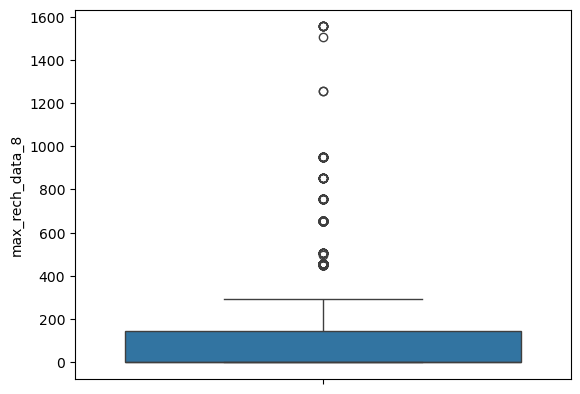

In [70]:
sns.boxplot(data=HVC_telecom, y='max_rech_data_8')


<Axes: ylabel='max_rech_data_6'>

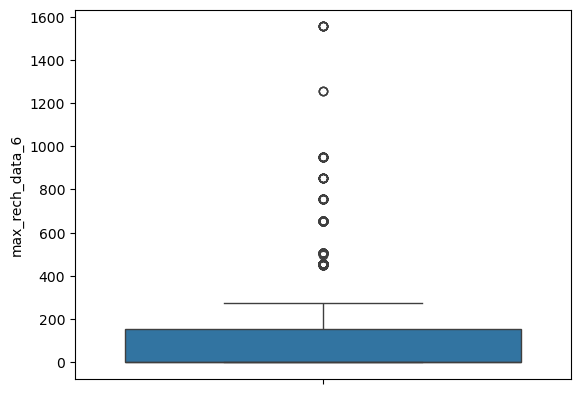

In [71]:
sns.boxplot(data=HVC_telecom, y='max_rech_data_6')


<Axes: ylabel='max_rech_data_7'>

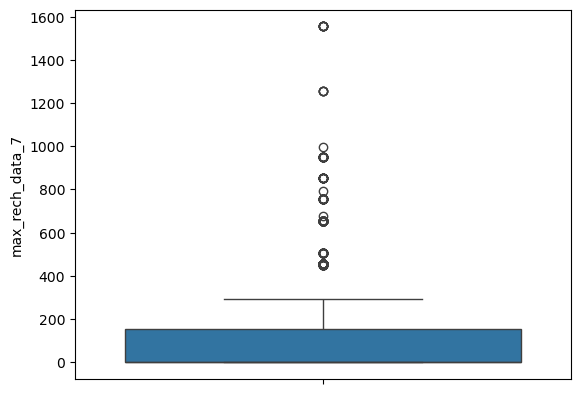

In [72]:
sns.boxplot(data=HVC_telecom, y='max_rech_data_7')

In [73]:
cols=['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 
             'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8']

HVC_telecom[(HVC_telecom['max_rech_data_6'] > 1200) & (HVC_telecom['max_rech_data_7'] > 1200)
           & (HVC_telecom['max_rech_data_8'] > 1200)][cols]

,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8
11530,1,2,1,1555.0,1555.0,1505.0,1555.0,2506.0,1505.0
27531,4,3,3,1555.0,1555.0,1555.0,5920.0,4365.0,4061.0
36883,1,1,1,1555.0,1555.0,1555.0,1555.0,1555.0,1555.0
46998,2,3,2,1555.0,1555.0,1555.0,3110.0,3765.0,2506.0
80216,1,1,2,1555.0,1555.0,1555.0,1555.0,1555.0,2506.0
81699,1,1,2,1555.0,1555.0,1555.0,1555.0,1555.0,1580.0


In [74]:
HVC_telecom = HVC_telecom[(HVC_telecom['max_rech_data_6'] < 1200) & (HVC_telecom['max_rech_data_7'] < 1200)
           & (HVC_telecom['max_rech_data_8'] < 1200)]

<Axes: ylabel='max_rech_data_8'>

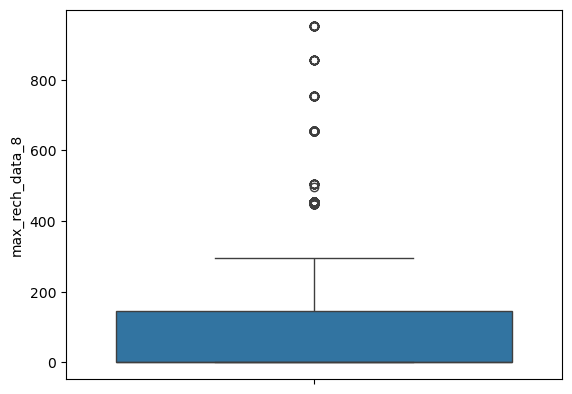

In [75]:
sns.boxplot(data=HVC_telecom, y='max_rech_data_8')

In [76]:
cols=['total_rech_data_6', 'max_rech_data_6', 'av_rech_amt_data_6']

HVC_telecom[(HVC_telecom['total_rech_data_6'] > 1) & 
            (HVC_telecom['total_rech_data_6'] * HVC_telecom['max_rech_data_6'] == HVC_telecom['av_rech_amt_data_6'])][cols]


,total_rech_data_6,max_rech_data_6,av_rech_amt_data_6
149,2,152.0,304.0
170,2,198.0,396.0
176,2,252.0,504.0
188,2,252.0,504.0
204,2,252.0,504.0
...,...,...,...
99598,3,252.0,756.0
99628,2,152.0,304.0
99822,2,252.0,504.0
99899,2,252.0,504.0


In [77]:
cols=['total_rech_data_7', 'max_rech_data_7', 'av_rech_amt_data_7']

HVC_telecom[(HVC_telecom['total_rech_data_7'] > 1) & 
            (HVC_telecom['total_rech_data_7'] * HVC_telecom['max_rech_data_7'] == HVC_telecom['av_rech_amt_data_7'])][cols]


,total_rech_data_7,max_rech_data_7,av_rech_amt_data_7
87,2,154.0,308.0
134,2,152.0,304.0
147,2,152.0,304.0
149,2,152.0,304.0
191,3,252.0,756.0
...,...,...,...
99857,2,14.0,28.0
99923,2,252.0,504.0
99925,2,91.0,182.0
99927,2,152.0,304.0


In [78]:
cols=['total_rech_data_8', 'max_rech_data_8', 'av_rech_amt_data_8']

HVC_telecom[(HVC_telecom['total_rech_data_8'] > 1) & 
            (HVC_telecom['total_rech_data_8'] * HVC_telecom['max_rech_data_8'] == HVC_telecom['av_rech_amt_data_8'])][cols]


,total_rech_data_8,max_rech_data_8,av_rech_amt_data_8
13,3,23.0,69.0
102,4,23.0,92.0
115,2,179.0,358.0
149,4,152.0,608.0
176,3,17.0,51.0
...,...,...,...
99670,3,23.0,69.0
99808,6,23.0,138.0
99923,2,252.0,504.0
99925,2,91.0,182.0


In [79]:
cols = ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 
             'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8']

In [80]:
wrong_cal = HVC_telecom[(HVC_telecom['total_rech_data_6'] > 1) & 
            (HVC_telecom['total_rech_data_6'] * HVC_telecom['max_rech_data_6'] == HVC_telecom['av_rech_amt_data_6']) & 
            (HVC_telecom['total_rech_data_7'] > 1) & 
            (HVC_telecom['total_rech_data_7'] * HVC_telecom['max_rech_data_7'] == HVC_telecom['av_rech_amt_data_7']) & 
            (HVC_telecom['total_rech_data_8'] > 1) & 
            (HVC_telecom['total_rech_data_8'] * HVC_telecom['max_rech_data_8'] == HVC_telecom['av_rech_amt_data_8'])]

print(wrong_cal.shape)
print(wrong_cal.Churn.sum())


(329, 156)
5


In [81]:
HVC_telecom.drop(wrong_cal.index, inplace=True)

In [82]:
HVC_telecom.Churn.sum()


2593

In [83]:
cols=['total_rech_data_6', 'max_rech_data_6', 'av_rech_amt_data_6', 'Churn']

HVC_telecom[(HVC_telecom['total_rech_data_6'] > 1) & 
            (HVC_telecom['total_rech_data_6'] * HVC_telecom['max_rech_data_6'] == HVC_telecom['av_rech_amt_data_6'])].Churn.sum()


114

In [84]:
cols=['total_rech_data_7', 'max_rech_data_7', 'av_rech_amt_data_7', 'Churn']

HVC_telecom[(HVC_telecom['total_rech_data_7'] > 1) & 
            (HVC_telecom['total_rech_data_7'] * HVC_telecom['max_rech_data_7'] == HVC_telecom['av_rech_amt_data_7'])].Churn.sum()


83

In [85]:
cols=['total_rech_data_8', 'max_rech_data_8', 'av_rech_amt_data_8', 'Churn']

HVC_telecom[(HVC_telecom['total_rech_data_8'] > 1) & 
            (HVC_telecom['total_rech_data_8'] * HVC_telecom['max_rech_data_8'] == HVC_telecom['av_rech_amt_data_8'])].Churn.sum()


36

In [86]:
def cal_av_rech_data(df, col):
    if((df['total_rech_data_'+col] > 1) & 
            (df['total_rech_data_'+col] * df['max_rech_data_'+col] == df['av_rech_amt_data_'+col])).all():
        return df['max_rech_data_'+col]/df['total_rech_data_'+col]
    else:
        return df['av_rech_amt_data_'+col]

# Applying the function for all months
HVC_telecom['av_rech_amt_data_6'] = cal_av_rech_data(HVC_telecom, "6")
HVC_telecom['av_rech_amt_data_7'] = cal_av_rech_data(HVC_telecom, "7")
HVC_telecom['av_rech_amt_data_8'] = cal_av_rech_data(HVC_telecom, "8")


In [87]:
HVC_telecom[['av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8']]

,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8
0,252.0,252.0,252.0
7,0.0,0.0,0.0
9,0.0,154.0,0.0
13,0.0,0.0,69.0
16,0.0,0.0,0.0
...,...,...,...
99985,0.0,0.0,0.0
99986,17.0,14.0,25.0
99989,0.0,0.0,0.0
99997,583.0,358.0,716.0


In [88]:
HVC_telecom.drop(columns=['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8'], axis=1, inplace=True)

HVC_telecom.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,Churn,last_rech_day_6,last_rech_day_7,last_rech_day_8
0,197.385,214.816,213.803,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1,968,30.40,0.00,101.20,3.58,1,9,15,23
7,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,...,0,802,57.74,19.38,18.74,0.00,1,3,6,5
9,119.518,247.435,170.231,33.89,30.11,22.43,63.48,54.16,78.34,0.00,...,0,902,0.00,0.00,0.00,0.00,0,1,8,2
13,492.846,205.671,593.260,501.76,108.39,534.24,413.31,119.28,482.46,23.53,...,1,2607,0.00,0.00,0.00,0.00,0,10,9,1
16,430.975,299.869,187.894,50.51,74.01,70.61,296.29,229.74,162.76,0.00,...,0,511,0.00,2.45,21.89,0.00,0,0,0,17


In [89]:
cols_6_7 = [col for col in HVC_telecom.columns if ("_6" in col) or ("_7" in col)]

for i,v in enumerate(cols_6_7):
    if("_6" in v):
        col = "av_"+v.split("6")[0]+"good"
        HVC_telecom[col] = (HVC_telecom[v] + HVC_telecom[cols_6_7[i+1]])/2

# Dropping the previous 6 and 7 attributes
HVC_telecom.drop(columns=cols_6_7, axis=1, inplace=True)

HVC_telecom.head()


,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,...,av_vol_3g_mb_good,av_arpu_3g_good,av_arpu_2g_good,av_night_pck_user_good,av_monthly_2g_good,av_sachet_2g_good,av_monthly_3g_good,av_sachet_3g_good,av_fb_user_good,av_last_rech_day_good
0,213.803,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,117.165,212.17,212.17,0.0,0.0,0.0,1.0,0.0,1.0,12.0
7,3171.480,52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,255.79,...,0.000,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,4.5
9,170.231,22.43,78.34,0.00,0.00,22.43,34.93,0.00,0.00,57.36,...,0.000,0.00,0.00,0.0,0.5,0.0,0.0,0.0,0.5,4.5
13,593.260,534.24,482.46,72.11,1.44,36.01,294.46,23.51,0.49,353.99,...,0.000,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,9.5
16,187.894,70.61,162.76,0.00,0.00,67.38,128.28,10.26,0.00,205.93,...,0.000,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
missing_percent = pd.DataFrame(round(100*(HVC_telecom.isnull().sum()/len(HVC_telecom.index)), 2), columns=['Percentage'])
missing_percent.reset_index(inplace=True)
missing_percent.rename(columns={'index':'features'}, inplace=True)

print("missing percentage < 10% ", missing_percent[(missing_percent['Percentage'] > 0.00) & (missing_percent['Percentage'] < 10.00)].count())
print("missing percentage 10-60% ", missing_percent[(missing_percent['Percentage'] >= 10.00) & (missing_percent['Percentage'] < 60.00)].count())
print("missing percentage >= 60% ", missing_percent[(missing_percent['Percentage'] >= 60.00)].count())


missing percentage < 10%  features      0
Percentage    0
dtype: int64
missing percentage 10-60%  features      0
Percentage    0
dtype: int64
missing percentage >= 60%  features      0
Percentage    0
dtype: int64


In [91]:
HVC_telecom.to_csv("HVC_telecom_cleaned_1.csv")


In [92]:
HVC_telecom = pd.read_csv("HVC_telecom_cleaned_1.csv")
HVC_telecom.drop("Unnamed: 0", axis=1, inplace=True)

HVC_telecom.head()


,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,...,av_vol_3g_mb_good,av_arpu_3g_good,av_arpu_2g_good,av_night_pck_user_good,av_monthly_2g_good,av_sachet_2g_good,av_monthly_3g_good,av_sachet_3g_good,av_fb_user_good,av_last_rech_day_good
0,213.803,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,117.165,212.17,212.17,0.0,0.0,0.0,1.0,0.0,1.0,12.0
1,3171.480,52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,255.79,...,0.000,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,4.5
2,170.231,22.43,78.34,0.00,0.00,22.43,34.93,0.00,0.00,57.36,...,0.000,0.00,0.00,0.0,0.5,0.0,0.0,0.0,0.5,4.5
3,593.260,534.24,482.46,72.11,1.44,36.01,294.46,23.51,0.49,353.99,...,0.000,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,9.5
4,187.894,70.61,162.76,0.00,0.00,67.38,128.28,10.26,0.00,205.93,...,0.000,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
X = HVC_telecom.drop('Churn', axis = 1)
y = HVC_telecom['Churn']

# Now will split the data into train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state=100)


In [94]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [95]:
# We will apply PCA on train data set
X_train.shape

(20717, 103)

In [96]:
pca = PCA(svd_solver='randomized', random_state=50)

#Doing the PCA on the train data
pca.fit(X_train)


PCA(random_state=50, svd_solver='randomized')

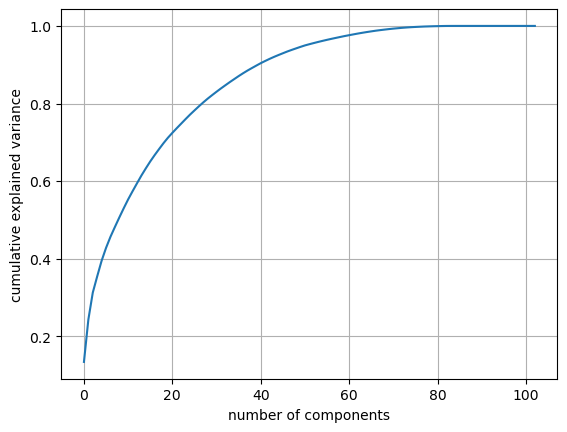

In [97]:
get_ipython().run_line_magic('matplotlib', 'inline')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.grid("grey")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [99]:
pca_final = IncrementalPCA(n_components=50)

# Transforming the X_train final 50 components PCA
df_train_pca = pca_final.fit_transform(X_train)
df_train_pca.shape


(20717, 50)

In [100]:
corrmat = np.corrcoef(df_train_pca.transpose())
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)

max corr: 0.033099426149967436 , min corr:  -0.11784858135179223


In [101]:
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

(8879, 50)

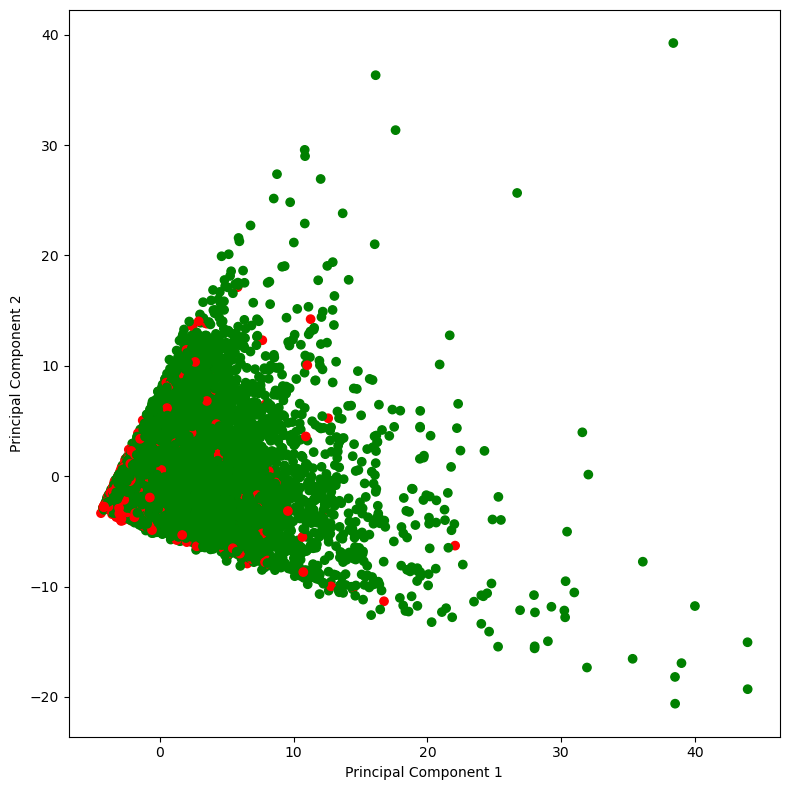

In [102]:
get_ipython().run_line_magic('matplotlib', 'inline')
fig = plt.figure(figsize = (8,8))
plt.scatter(df_train_pca[:,0], df_train_pca[:,1], c = y_train.map({0:'green',1:'red'}))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

In [103]:
logReg = LogisticRegression(class_weight='balanced')
model = logReg.fit(df_train_pca, y_train)

# predicting the Churn/Non-Churn using the model
y_pred = model.predict(df_test_pca)

print("Accuracy Score {0}:".format(metrics.accuracy_score(y_test, y_pred)))
print("Sensitivity/Recall {0}:".format(metrics.recall_score(y_test, y_pred)))
metrics.confusion_matrix(y_test, y_pred)


Accuracy Score 0.8139430116004055:
Sensitivity/Recall 0.8691709844559585:


array([[6556, 1551],
       [ 101,  671]], dtype=int64)

In [104]:
logR = LogisticRegression(class_weight='balanced')
params = {'penalty': ['l1', 'l2'],
             'C':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 1]}

# Applying the GridSearch using scoring as recall
grid = GridSearchCV(estimator= logR, param_grid=params, cv=5, verbose=1, scoring='recall',return_train_score=True)
grid.fit(df_train_pca, y_train)

print("Best train Score: ",grid.best_score_)
print("Best Parameter: ",grid.best_params_)

# Applying GridSearch Parameters on LogisticRegression
logReg = LogisticRegression(penalty=grid.best_params_['penalty'], 
                            C=grid.best_params_['C'], class_weight='balanced')
model = logReg.fit(df_train_pca, y_train)

# predicting the Churn/Non-Churn using the model
y_pred = model.predict(df_test_pca)

# Validating the Accuracy, Recall and Confusion matrix
print("Accuracy Score {0}:".format(metrics.accuracy_score(y_test, y_pred)))
print("Sensitivity/Recall {0}:".format(metrics.recall_score(y_test, y_pred)))
metrics.confusion_matrix(y_test, y_pred)


Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best train Score:  0.8544859250338701
Best Parameter:  {'C': 0.5, 'penalty': 'l2'}
Accuracy Score 0.813830386304764:
Sensitivity/Recall 0.8691709844559585:


array([[6555, 1552],
       [ 101,  671]], dtype=int64)

In [105]:
rfc = RandomForestClassifier(class_weight='balanced')
model2 = rfc.fit(df_train_pca, y_train)

# predicting the Churn/Non-Churn using the model
y_pred = model2.predict(df_test_pca)

# Validating the Accuracy, Recall and Confusion matrix
print("Accuracy Score {0}:".format(metrics.accuracy_score(y_test, y_pred)))
print("Sensitivity/Recall {0}:".format(metrics.recall_score(y_test, y_pred)))
metrics.confusion_matrix(y_test, y_pred)


Accuracy Score 0.9266809325374479:
Sensitivity/Recall 0.2538860103626943:


array([[8032,   75],
       [ 576,  196]], dtype=int64)

In [106]:
logR = LogisticRegression(class_weight='balanced')
params = {'penalty': ['l1', 'l2'],
            'C':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 1],
            'l1_ratio':[0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1]}
grid = GridSearchCV(estimator= logR, param_grid=params, cv=5, verbose=1, scoring='recall',return_train_score=True)
grid.fit(df_train_pca, y_train)

print("Elastic Net Train score: {0}".format(grid.best_score_))
print("Elastic Net params: {0}".format(grid.best_params_))

logReg = LogisticRegression(penalty=grid.best_params_['penalty'], C=grid.best_params_['C'],
                            class_weight='balanced', l1_ratio= grid.best_params_['l1_ratio'])
model = logReg.fit(df_train_pca, y_train)

# predicting the Churn/Non-Churn using the model
y_pred = model.predict(df_test_pca)

# Validating the Accuracy, Recall and Confusion matrix
print("Accuracy Score {0}:".format(metrics.accuracy_score(y_test, y_pred)))
print("Sensitivity/Recall {0}:".format(metrics.recall_score(y_test, y_pred)))
metrics.confusion_matrix(y_test, y_pred)


Fitting 5 folds for each of 98 candidates, totalling 490 fits
Elastic Net Train score: 0.8544859250338701
Elastic Net params: {'C': 0.5, 'l1_ratio': 0.1, 'penalty': 'l2'}
Accuracy Score 0.813830386304764:
Sensitivity/Recall 0.8691709844559585:


array([[6555, 1552],
       [ 101,  671]], dtype=int64)

In [107]:
logReg = LogisticRegression(penalty='l2', 
                            C=0.0001, class_weight='balanced')
classifier = logReg.fit(df_train_pca, y_train)

# predicting the Churn/Non-Churn using the model
y_pred = classifier.predict(df_test_pca)

# Validating the Accuracy, Recall and Confusion matrix
print("Accuracy Score {0}:".format(metrics.accuracy_score(y_test, y_pred)))
print("Sensitivity/Recall {0}:".format(metrics.recall_score(y_test, y_pred)))
metrics.confusion_matrix(y_test, y_pred)


Accuracy Score 0.7607838720576642:
Sensitivity/Recall 0.8639896373056994:


array([[6088, 2019],
       [ 105,  667]], dtype=int64)

In [ ]:
pickle.dump(classifier, open('./model/model.pkl', 'wb'))